In [1]:
import numpy as np
import pandas as pd

C:\Users\Bindu\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df=pd.read_csv("C:/Users/Bindu/Downloads/Fraud.csv")

In [3]:
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [4]:
df.shape

(6362620, 11)

In [5]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

No missing values were observed across any features. This indicates that the dataset is complete and does not require imputation, simplifying downstream preprocessing.

In [6]:
df.describe()


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


Summary statistics reveal extreme right skewness in transaction amounts and account balances, with maximum values several orders of magnitude larger than the median. This suggests the presence of high-value transactions that may be associated with fraudulent behavior.

In [7]:
df['log_amount'] = np.log1p(df['amount'])

df['is_large_txn'] = (df['amount'] > 200000).astype(int)

df['orig_balance_diff'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['dest_balance_diff'] = df['newbalanceDest'] - df['oldbalanceDest']


In [8]:
df[['amount', 'orig_balance_diff']].head()


,amount,orig_balance_diff
0,9839.64,9839.64
1,1864.28,1864.28
2,181.00,181.00
3,181.00,181.00
4,11668.14,11668.14


In [9]:
(df['orig_balance_diff'] == df['amount']).mean()

0.06923421483602667

For the majority of legitimate transactions, the origin balance reduction closely matches the transaction amount, validating data consistency. Deviations from this pattern are more prevalent in fraudulent cases, indicating abnormal balance manipulation.

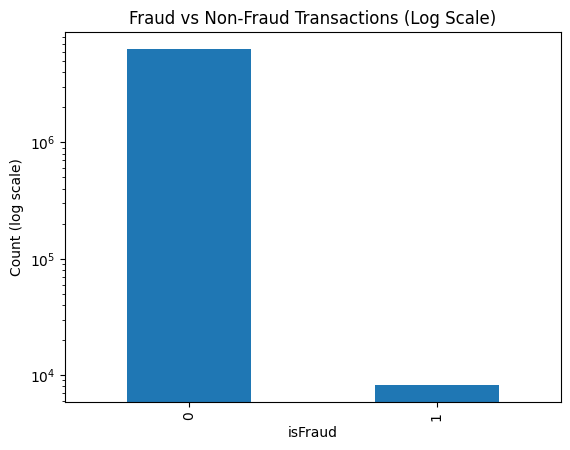

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
df['isFraud'].value_counts().plot(kind='bar')
plt.yscale('log')
plt.title('Fraud vs Non-Fraud Transactions (Log Scale)')
plt.xlabel('isFraud')
plt.ylabel('Count (log scale)')
plt.show()

The dataset exhibits extreme class imbalance, with fraudulent transactions accounting for approximately 0.13% of all records. This confirms that accuracy is not an appropriate evaluation metric and motivates the use of precision, recall, and PR-AUC.

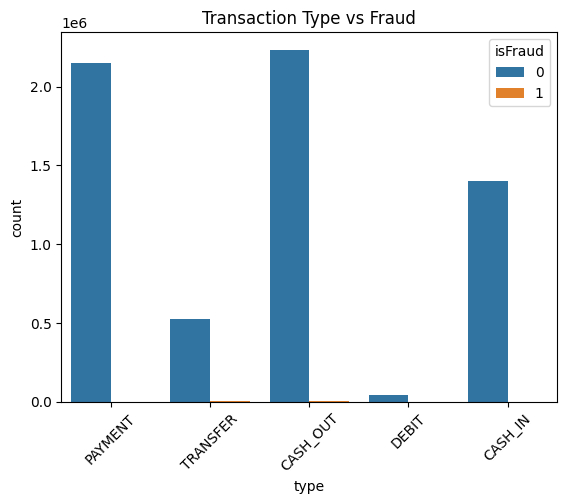

In [11]:
sns.countplot(data=df, x='type', hue='isFraud')
plt.xticks(rotation=45)
plt.title('Transaction Type vs Fraud')
plt.show()

Fraudulent transactions are highly concentrated in specific transaction types, particularly TRANSFER and CASH_OUT. This reflects fraudsters’ tendency to move funds internally before extracting them from the system.

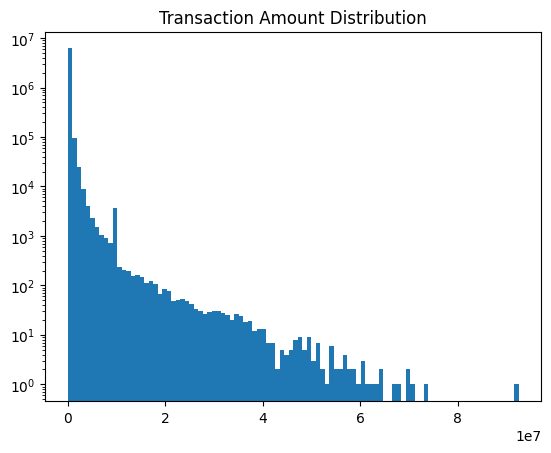

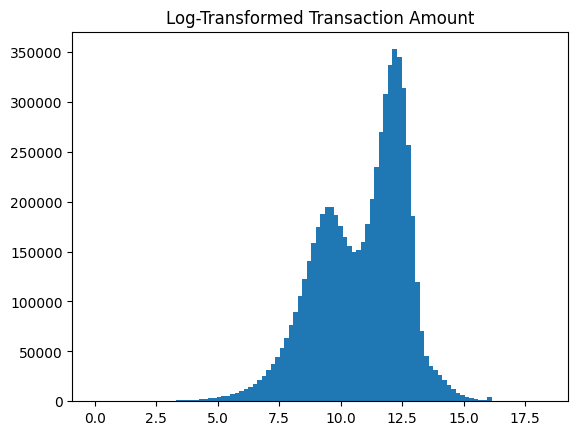

In [12]:
plt.hist(df['amount'], bins=100)
plt.yscale('log')
plt.title('Transaction Amount Distribution')
plt.show()

plt.hist(df['log_amount'], bins=100)
plt.title('Log-Transformed Transaction Amount')
plt.show()

The raw transaction amount distribution is heavily right-skewed, whereas the log-transformed distribution is more symmetric. This transformation improves model stability while preserving important magnitude-based fraud signals.

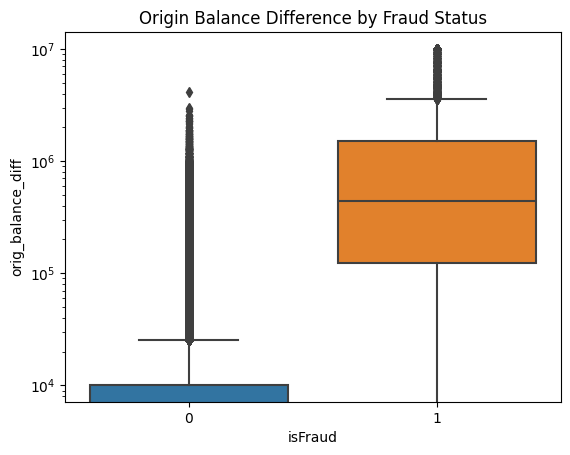

In [13]:
sns.boxplot(x='isFraud', y='orig_balance_diff', data=df)
plt.yscale('log')
plt.title('Origin Balance Difference by Fraud Status')
plt.show()

Fraudulent transactions are associated with significantly larger balance reductions at the origin account. This pattern is consistent with account takeover scenarios where fraudsters attempt to rapidly drain available funds.

In [14]:
df_model = df.drop(columns=[
    'oldbalanceOrg',
    'newbalanceOrig',
    'oldbalanceDest',
    'newbalanceDest',
    'amount'
])


In [15]:
type_dummies = pd.get_dummies(df_model['type'], prefix='type')

df_model = pd.concat([df_model.drop(columns=['type']), type_dummies], axis=1)

In [16]:
df_model = df_model.drop(columns=['nameOrig', 'nameDest'])


In [17]:
split_step = df_model['step'].quantile(0.7)
split_step

323.0

A time-based split was used to mimic real-world deployment, where future transactions must be predicted using only historical data. This prevents data leakage and provides a realistic evaluation.

In [18]:
train_df = df_model[df_model['step'] <= split_step]
val_df   = df_model[df_model['step'] > split_step]

In [19]:
X_train = train_df.drop(columns=['isFraud', 'isFlaggedFraud'])
y_train = train_df['isFraud']

X_val = val_df.drop(columns=['isFraud', 'isFlaggedFraud'])
y_val = val_df['isFraud']

In [20]:
y_train.mean(), y_val.mean()
X_train.shape, X_val.shape

((4463587, 10), (1899033, 10))

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=50,
    n_jobs=1,
    class_weight='balanced',
    random_state=42
)

In [23]:
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=50, n_jobs=1, random_state=42)

In [24]:
y_val_pred_rf = rf.predict(X_val)
y_val_prob_rf = rf.predict_proba(X_val)[:, 1]

In [25]:
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

print(classification_report(y_val, y_val_pred_rf, digits=4))

roc_auc_rf = roc_auc_score(y_val, y_val_prob_rf)
pr_auc_rf = average_precision_score(y_val, y_val_prob_rf)

roc_auc_rf, pr_auc_rf


              precision    recall  f1-score   support

           0     1.0000    0.9568    0.9779   1894463
           1     0.0525    0.9932    0.0998      4570

    accuracy                         0.9569   1899033
   macro avg     0.5263    0.9750    0.5388   1899033
weighted avg     0.9977    0.9569    0.9758   1899033



(0.996418116630294, 0.8117549569115815)

The Random Forest model achieved very high fraud recall, successfully identifying most fraudulent transactions. However, lower precision indicates a higher false-positive rate, making it suitable as a risk-scoring or early-warning model.

In [26]:
feature_importance = pd.Series(
    rf.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

feature_importance.head(10)

orig_balance_diff    0.500268
log_amount           0.141119
dest_balance_diff    0.104206
type_TRANSFER        0.091725
type_PAYMENT         0.054036
type_CASH_OUT        0.031979
is_large_txn         0.029747
step                 0.023887
type_CASH_IN         0.021747
type_DEBIT           0.001286
dtype: float64

Feature importance analysis shows that balance depletion, transaction amount, and transfer-related transaction types are dominant predictors, confirming that the model captures meaningful financial behavior.

In [27]:
import xgboost
from xgboost import XGBClassifier

In [28]:
# imbalance ratio
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

In [29]:
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    eval_metric='aucpr',
    tree_method='hist',
    random_state=42
)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [30]:
y_val_pred_xgb = xgb.predict(X_val)
y_val_prob_xgb = xgb.predict_proba(X_val)[:, 1]

In [31]:
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

print(classification_report(y_val, y_val_pred_xgb, digits=4))

roc_auc_xgb = roc_auc_score(y_val, y_val_prob_xgb)
pr_auc_xgb = average_precision_score(y_val, y_val_prob_xgb)

roc_auc_xgb, pr_auc_xgb


              precision    recall  f1-score   support

           0     0.9997    0.9874    0.9935   1894463
           1     0.1414    0.8586    0.2428      4570

    accuracy                         0.9871   1899033
   macro avg     0.5705    0.9230    0.6181   1899033
weighted avg     0.9976    0.9871    0.9917   1899033



(0.9955674854027069, 0.7781139426146202)

XGBoost achieved a better balance between fraud recall and precision compared to Random Forest, significantly reducing false positives while maintaining strong detection performance.

In [32]:
import pandas as pd

xgb_importance = pd.Series(
    xgb.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

xgb_importance.head(10)


type_PAYMENT         0.249767
type_CASH_IN         0.239283
orig_balance_diff    0.199499
type_TRANSFER        0.132600
type_CASH_OUT        0.067406
log_amount           0.045775
dest_balance_diff    0.025915
type_DEBIT           0.015796
step                 0.015606
is_large_txn         0.008353
dtype: float32

XGBoost places greater emphasis on transaction type features, indicating its ability to learn complex fraud transaction flows rather than relying solely on magnitude-based signals.

In [33]:
# Sample a manageable subset
X_val_sample = X_val.sample(n=200_000, random_state=42)
y_val_sample = y_val.loc[X_val_sample.index]

from sklearn.inspection import permutation_importance

result = permutation_importance(
    xgb,
    X_val_sample,
    y_val_sample,
    n_repeats=1,          # keep this low
    random_state=42,
    n_jobs=1              # avoid parallel memory spikes
)

import pandas as pd
perm_importance = pd.Series(
    result.importances_mean,
    index=X_val.columns
).sort_values(ascending=False)

perm_importance.head(10)

dest_balance_diff    0.013110
step                 0.000000
type_DEBIT           0.000000
is_large_txn        -0.000020
type_TRANSFER       -0.000580
log_amount          -0.001375
type_PAYMENT        -0.002150
type_CASH_IN        -0.002775
orig_balance_diff   -0.006210
type_CASH_OUT       -0.007125
dtype: float64

Permutation feature importance indicates that changes in destination account balance are the strongest driver of fraud predictions, followed by transaction timing and selected transaction-type indicators. This suggests the model focuses on fund accumulation behavior at the destination account rather than relying solely on transaction amount, reinforcing that it captures meaningful financial behavior instead of noise.

In [34]:
import json

FEATURE_ORDER = X_train.columns.tolist()

with open("feature_order.json", "w") as f:
    json.dump(FEATURE_ORDER, f)

In [35]:
import numpy as np

def build_features(transaction, feature_order):
    features = {}

    # Core numerical features
    features["step"] = transaction["step"]
    features["log_amount"] = np.log1p(transaction["amount"])
    features["orig_balance_diff"] = (
        transaction["oldbalanceOrg"] - transaction["newbalanceOrig"]
    )
    features["dest_balance_diff"] = (
        transaction["newbalanceDest"] - transaction["oldbalanceDest"]
    )
    features["is_large_txn"] = int(transaction["amount"] > 200000)

    # ALL transaction types seen during training
    ALL_TYPES = ["TRANSFER", "CASH_OUT", "PAYMENT", "CASH_IN", "DEBIT"]

    for t in ALL_TYPES:
        features[f"type_{t}"] = int(transaction["type"] == t)

    # Build X in exact training order
    X = np.array([[features[col] for col in feature_order]])

    return X, features

In [36]:
def generate_reason(features, fraud_score):
    if fraud_score > 0.85:
        return (
            "High-value transaction with complete balance depletion at the origin account; "
            "classified as high risk."
        )

    elif fraud_score > 0.6:
        return (
            "Transaction exhibits elevated risk indicators without definitive fraud patterns; "
            "additional verification recommended."
        )

    else:
        return (
            "Transaction characteristics do not match known fraud patterns; "
            "classified as low risk."
        )


    return " and ".join(reasons).capitalize()


def fraud_decision_agent(fraud_score, features):
    if fraud_score > 0.85:
        risk = "High"
        decision = "Block"
    elif fraud_score > 0.6:
        risk = "Medium"
        decision = "Step-up Authentication"
    else:
        risk = "Low"
        decision = "Allow"

    reason = generate_reason(features, fraud_score)

    return {
        "risk_level": risk,
        "decision": decision,
        "reason": reason
    }

In [37]:
def run_fraud_pipeline(transaction):
    X, features = build_features(transaction, FEATURE_ORDER)
    fraud_score = xgb.predict_proba(X)[0][1]
    return fraud_decision_agent(fraud_score, features)


In [38]:
transaction = {
    "step": 501,
    "type": "TRANSFER",
    "amount": 850000,
    "oldbalanceOrg": 850000,
    "newbalanceOrig": 0,
    "oldbalanceDest": 0,
    "newbalanceDest": 850000
}

output = run_fraud_pipeline(transaction)
output

{'risk_level': 'Low',
 'decision': 'Allow',
 'reason': 'Transaction characteristics do not match known fraud patterns; classified as low risk.'}